In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
# Configure plotting
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Load dataset
data = pd.read_csv('/titanic.csv')

In [4]:
# Display first few rows of the dataset
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
# Check for missing values
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


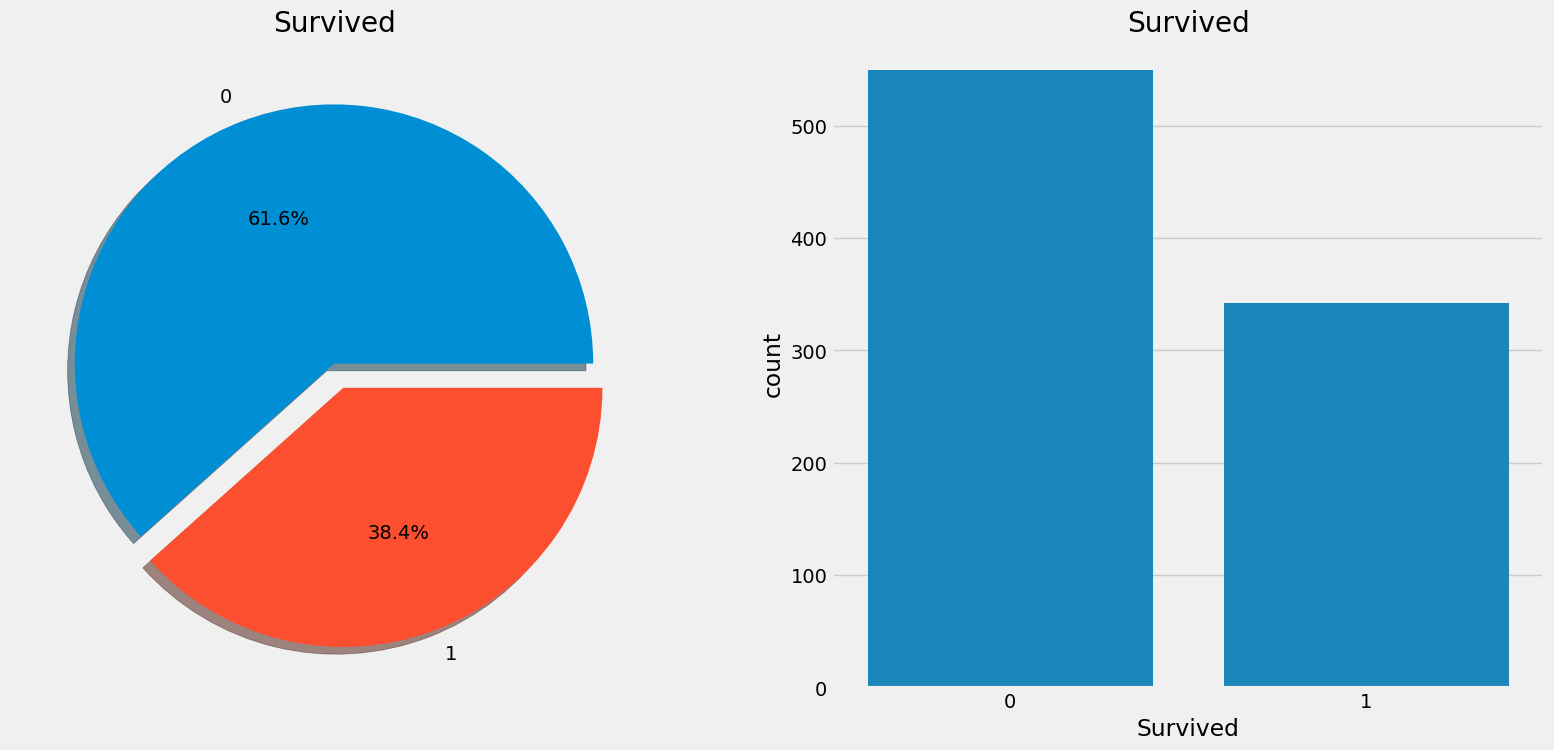

In [6]:
# Visualize survival counts
f, ax = plt.subplots(1, 2, figsize=(18, 8))
data['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

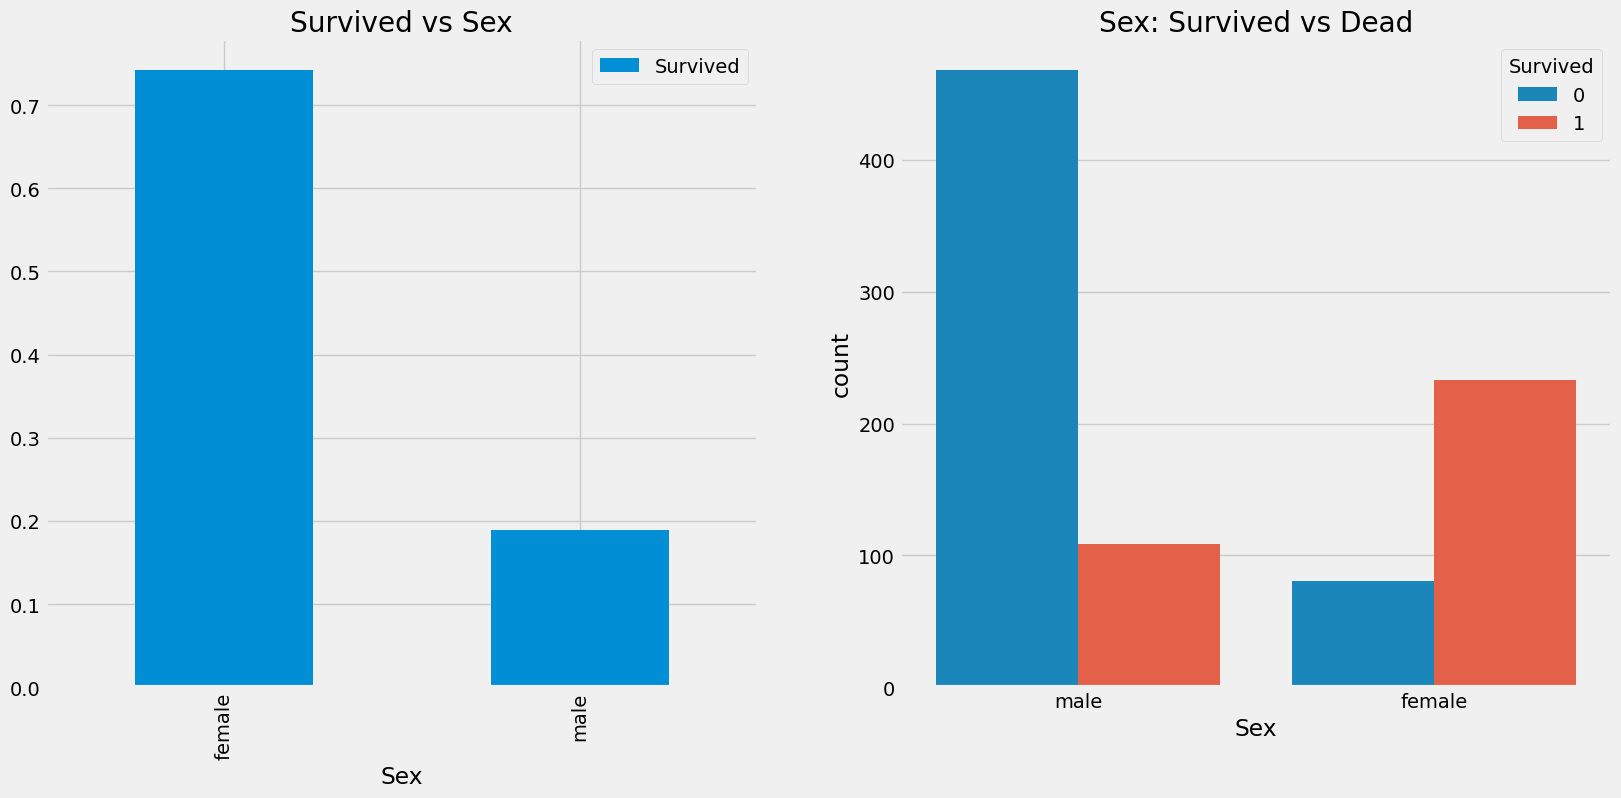

In [7]:
# Survival rates by sex
f, ax = plt.subplots(1, 2, figsize=(18, 8))
data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

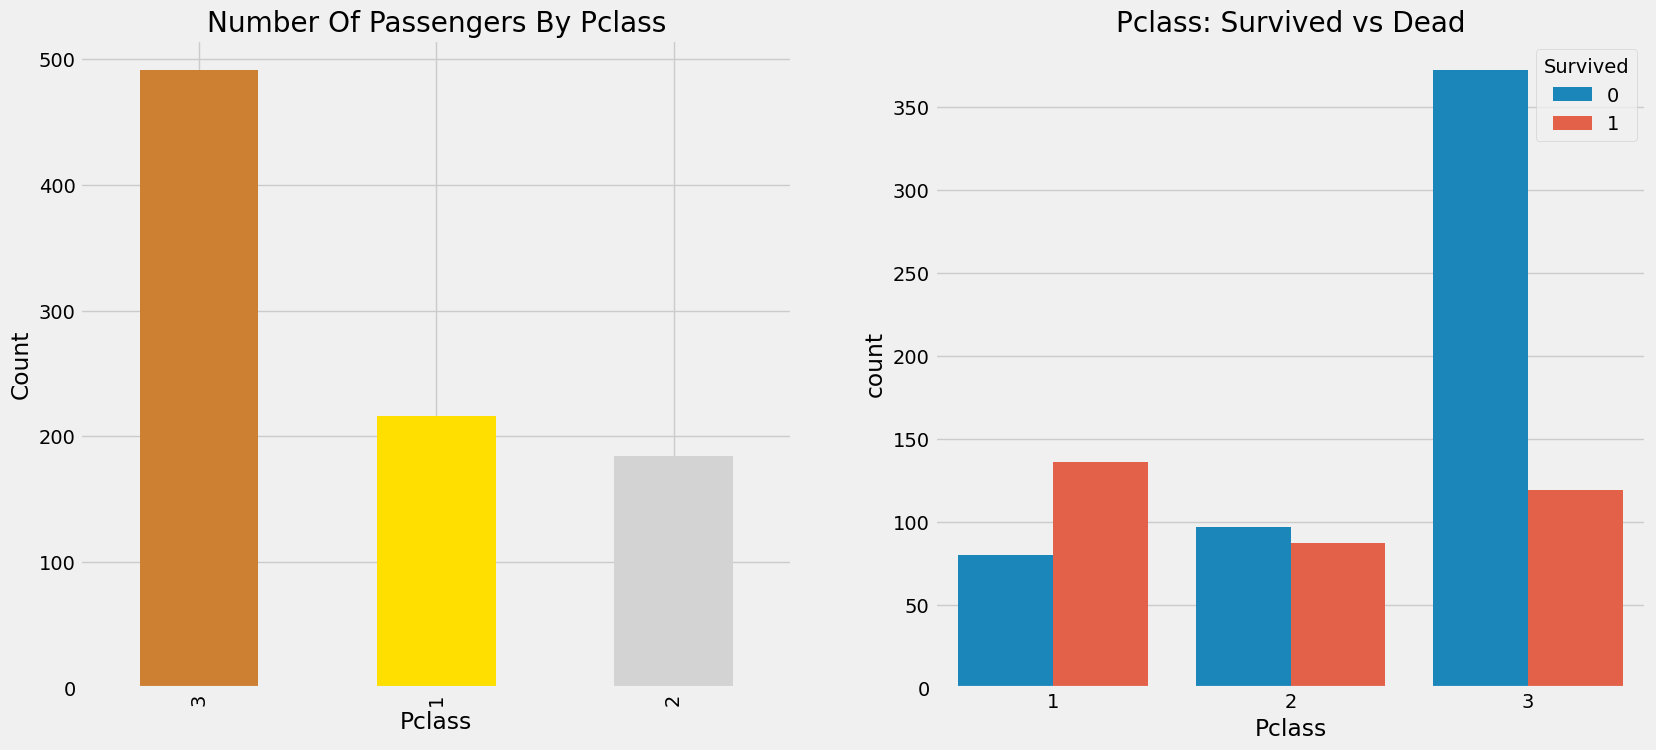

In [9]:
# Survival rates by class
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

f, ax = plt.subplots(1, 2, figsize=(18, 8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

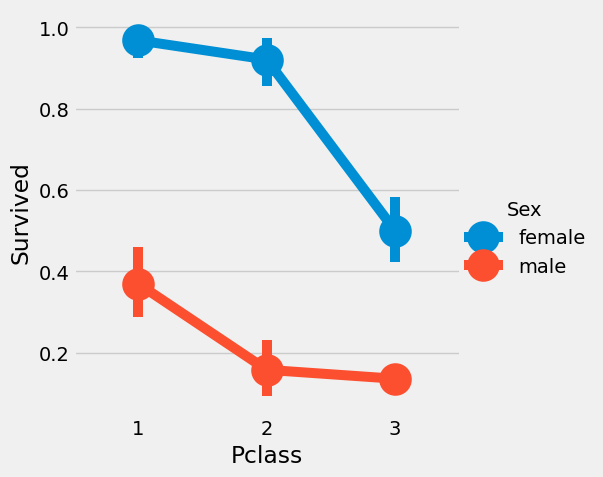

In [10]:
# Survival rates by class and sex
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=data, kind='point')
plt.show()

Oldest Passenger was: 80.0 Years
Youngest Passenger was: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


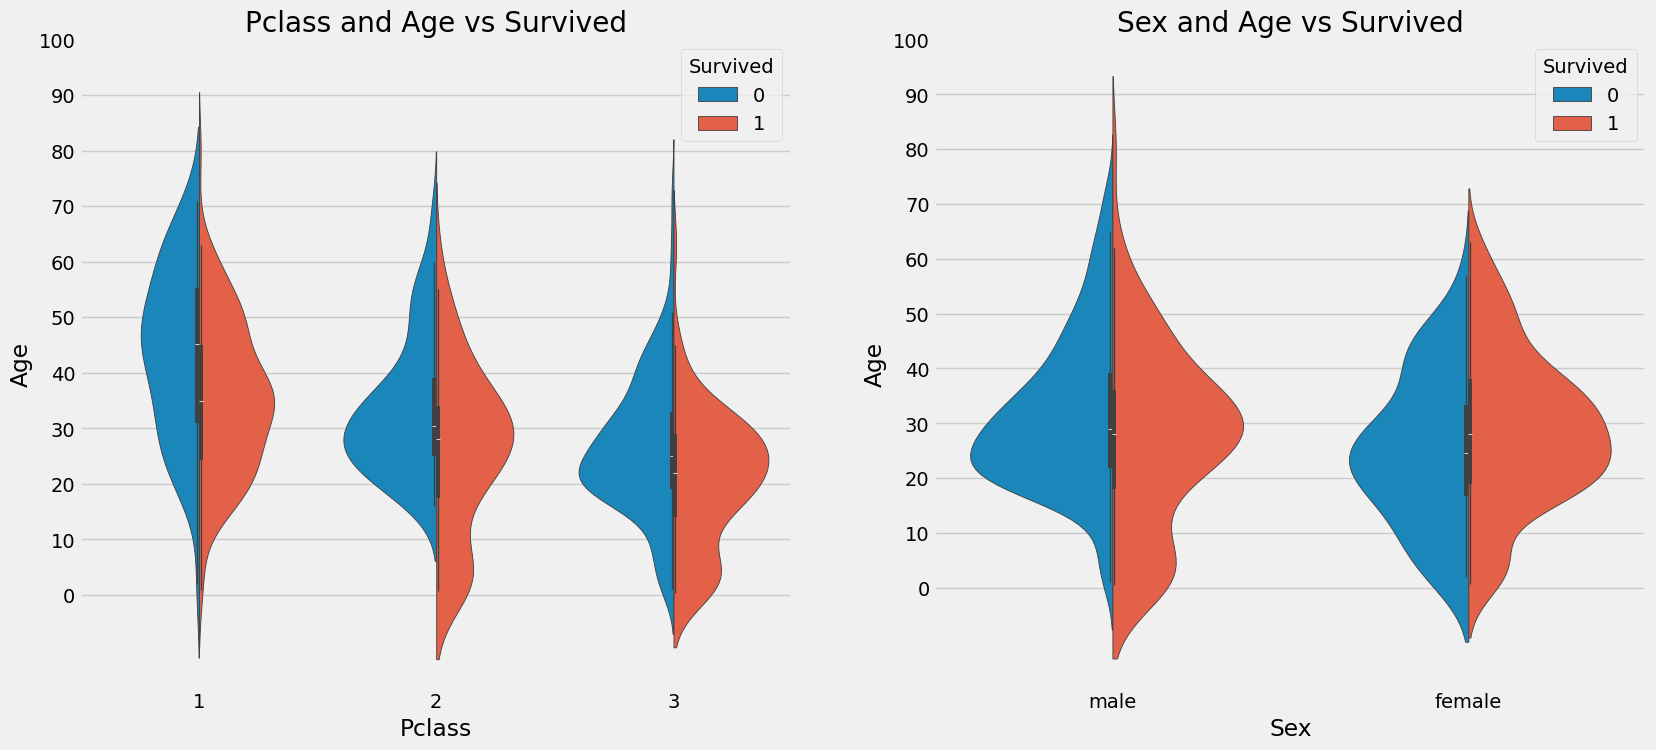

In [11]:
# Age statistics
print('Oldest Passenger was:', data['Age'].max(), 'Years')
print('Youngest Passenger was:', data['Age'].min(), 'Years')
print('Average Age on the ship:', data['Age'].mean(), 'Years')

f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x="Sex", y="Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

In [12]:
# Extract salutations from Name
data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')

In [13]:
# Map salutations to a more manageable set
salutation_map = {
    'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dr': 'Other', 'Major': 'Other',
    'Lady': 'Other', 'Countess': 'Other', 'Jonkheer': 'Other', 'Col': 'Other',
    'Rev': 'Other', 'Capt': 'Other', 'Sir': 'Other', 'Don': 'Other', 'Master': 'Master',
    'Miss': 'Miss', 'Mr': 'Mr', 'Mrs': 'Mrs'
}
data['Initial'] = data['Initial'].replace(salutation_map)

In [14]:
# Average age by salutation
print(data.groupby('Initial')['Age'].mean())

Initial
Master     4.574167
Miss      21.845638
Mr        32.368090
Mrs       35.788991
Other     45.545455
Name: Age, dtype: float64


In [15]:
# Fill missing age values based on salutation
age_fill_values = {
    'Mr': 33, 'Mrs': 36, 'Master': 5, 'Miss': 22, 'Other': 46
}
for initial, value in age_fill_values.items():
    data.loc[(data.Age.isnull()) & (data.Initial == initial), 'Age'] = value

In [16]:
# Verify no missing values
print(data.Age.isnull().any())

False


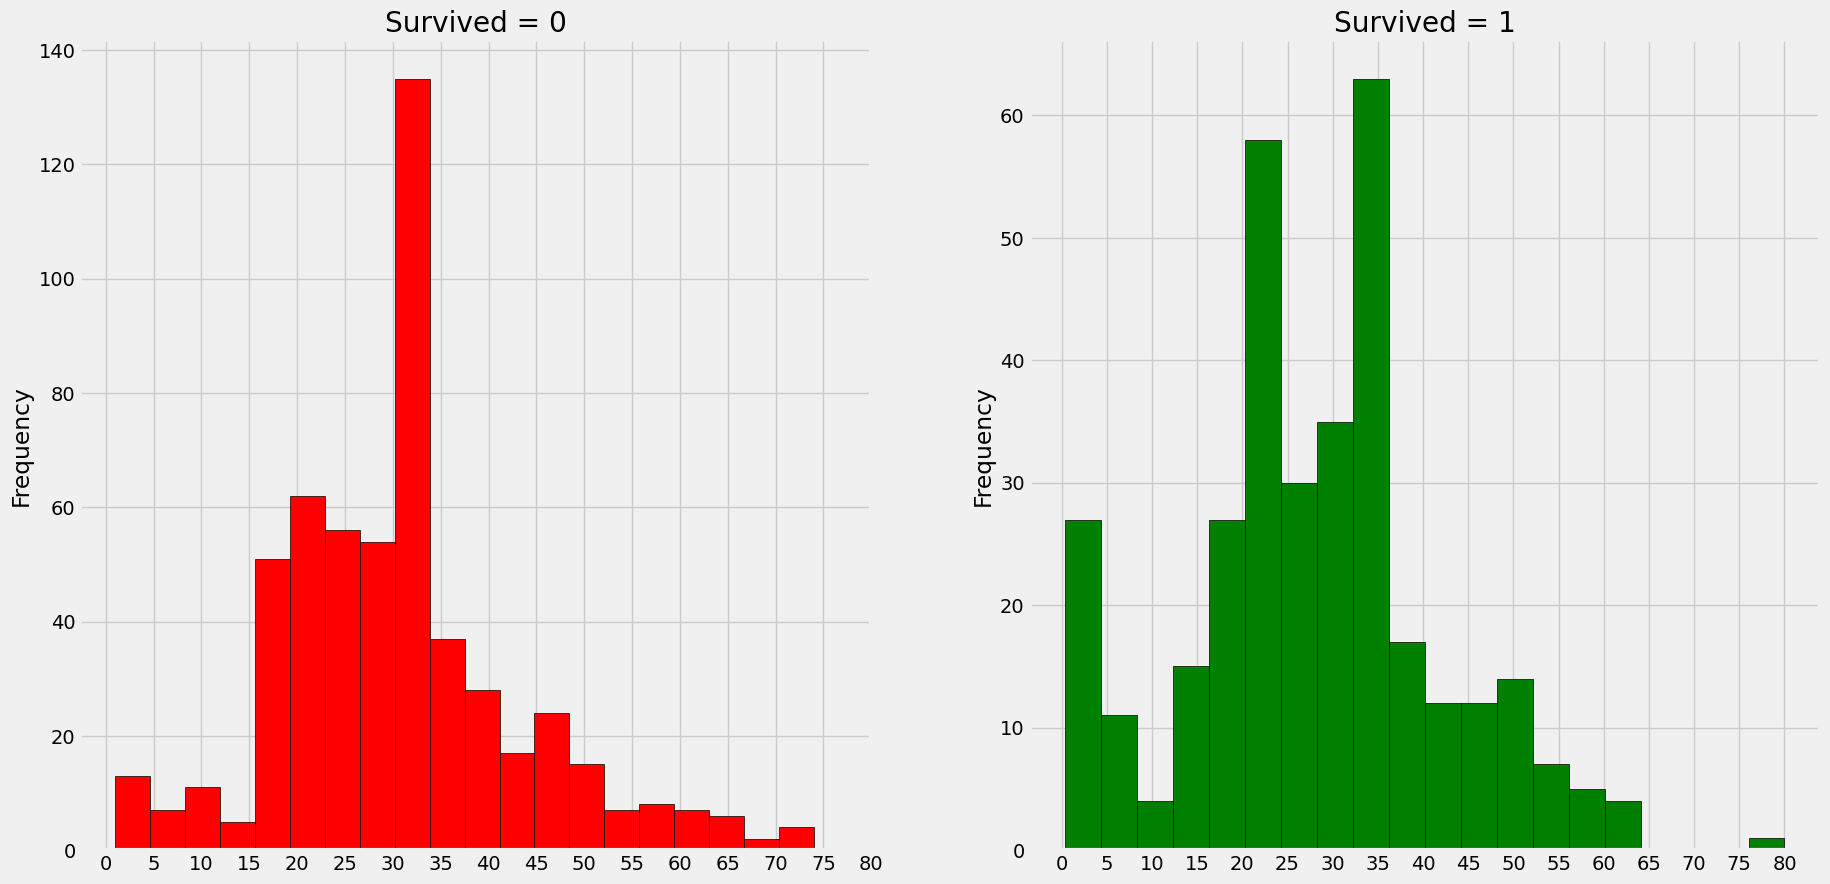

In [17]:
# Age distribution by survival
f, ax = plt.subplots(1, 2, figsize=(20, 10))
data[data['Survived'] == 0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Survived = 0')
x1 = list(range(0, 85, 5))
ax[0].set_xticks(x1)
data[data['Survived'] == 1].Age.plot.hist(ax=ax[1], color='green', bins=20, edgecolor='black')
ax[1].set_title('Survived = 1')
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)
plt.show()

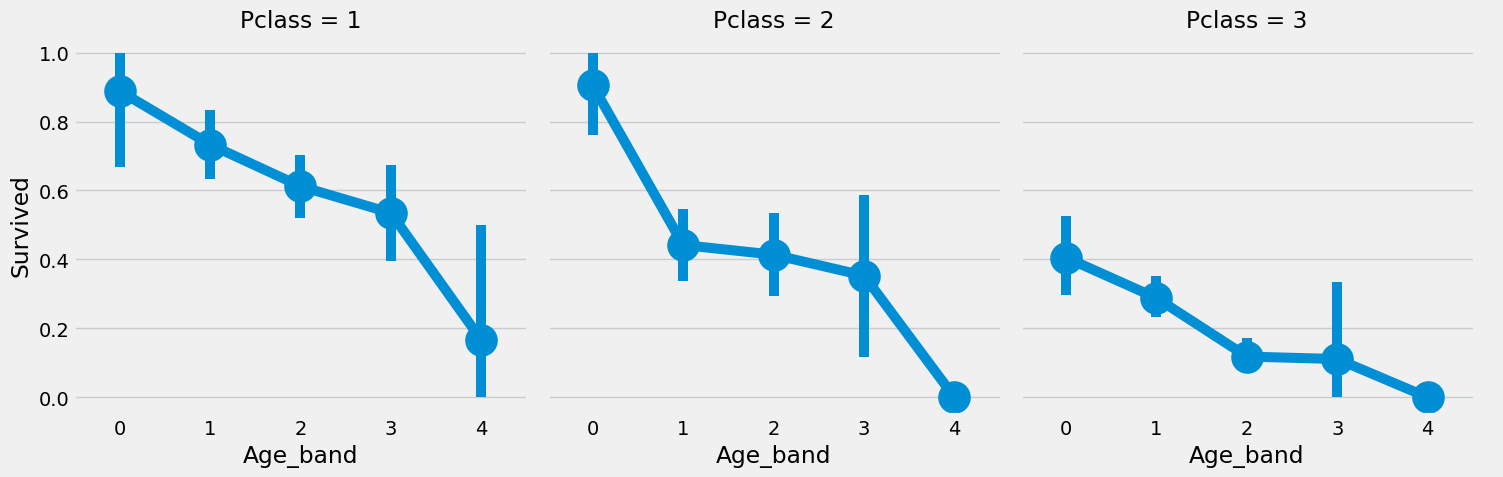

In [18]:
# Survival rates by age band
data['Age_band'] = pd.cut(data['Age'], bins=[0, 16, 32, 48, 64, np.inf], labels=[0, 1, 2, 3, 4])
sns.catplot(x='Age_band', y='Survived', data=data, col='Pclass', kind='point')
plt.show()

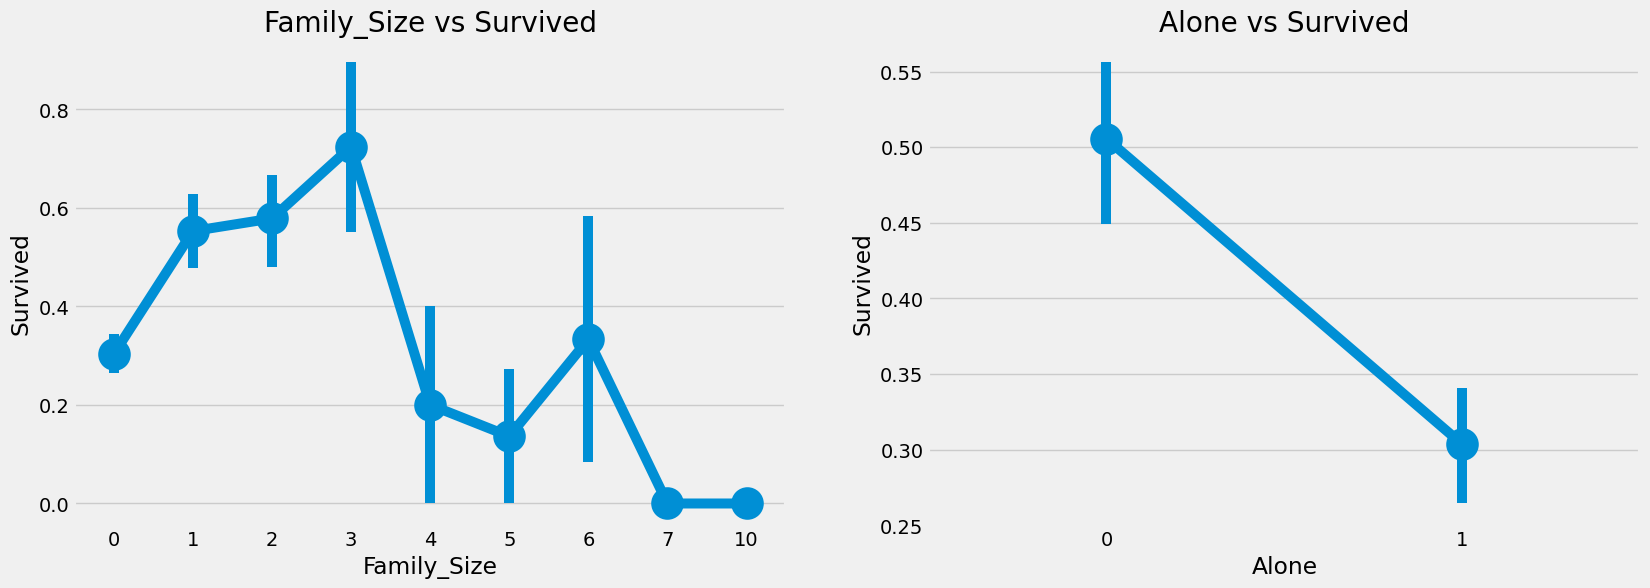

In [19]:
# Family size and survival
data['Family_Size'] = data['Parch'] + data['SibSp']
data['Alone'] = (data['Family_Size'] == 0).astype(int)

f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.pointplot(x='Family_Size', y='Survived', data=data, ax=axes[0])
axes[0].set_title('Family_Size vs Survived')
sns.pointplot(x='Alone', y='Survived', data=data, ax=axes[1])
axes[1].set_title('Alone vs Survived')
plt.show()

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


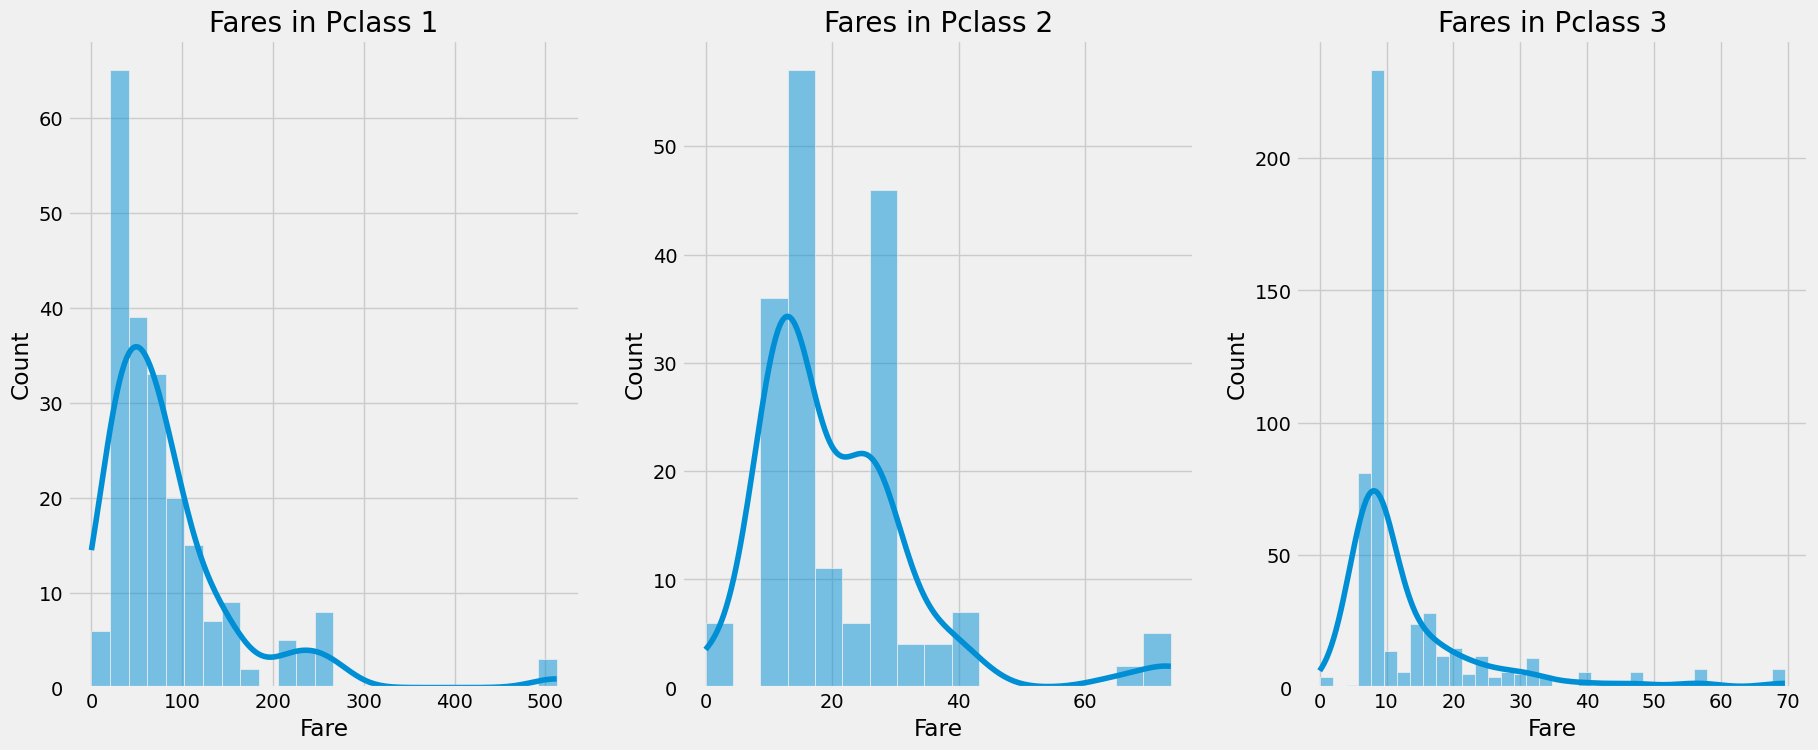

In [20]:
# Fare analysis
print('Highest Fare was:', data['Fare'].max())
print('Lowest Fare was:', data['Fare'].min())
print('Average Fare was:', data['Fare'].mean())

f, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.histplot(data[data['Pclass'] == 1].Fare, ax=ax[0], kde=True)
ax[0].set_title('Fares in Pclass 1')
sns.histplot(data[data['Pclass'] == 2].Fare, ax=ax[1], kde=True)
ax[1].set_title('Fares in Pclass 2')
sns.histplot(data[data['Pclass'] == 3].Fare, ax=ax[2], kde=True)
ax[2].set_title('Fares in Pclass 3')
plt.show()

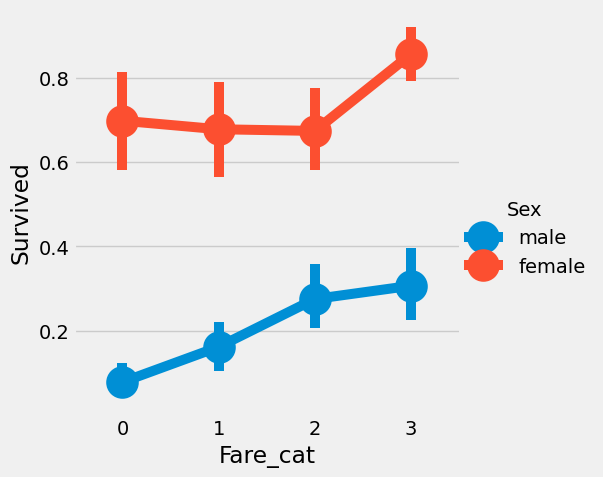

In [21]:
# Fare category
data['Fare_Range'] = pd.qcut(data['Fare'], 4)
print(data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r'))

data['Fare_cat'] = pd.cut(data['Fare'], bins=[-np.inf, 7.91, 14.454, 31, np.inf], labels=[0, 1, 2, 3])
sns.catplot(x='Fare_cat', y='Survived', data=data, hue='Sex', kind='point')
plt.show()

In [22]:
# Encoding categorical features
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)

In [23]:
# Drop unnecessary columns
data.drop(['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Fare_Range', 'PassengerId'], axis=1, inplace=True)

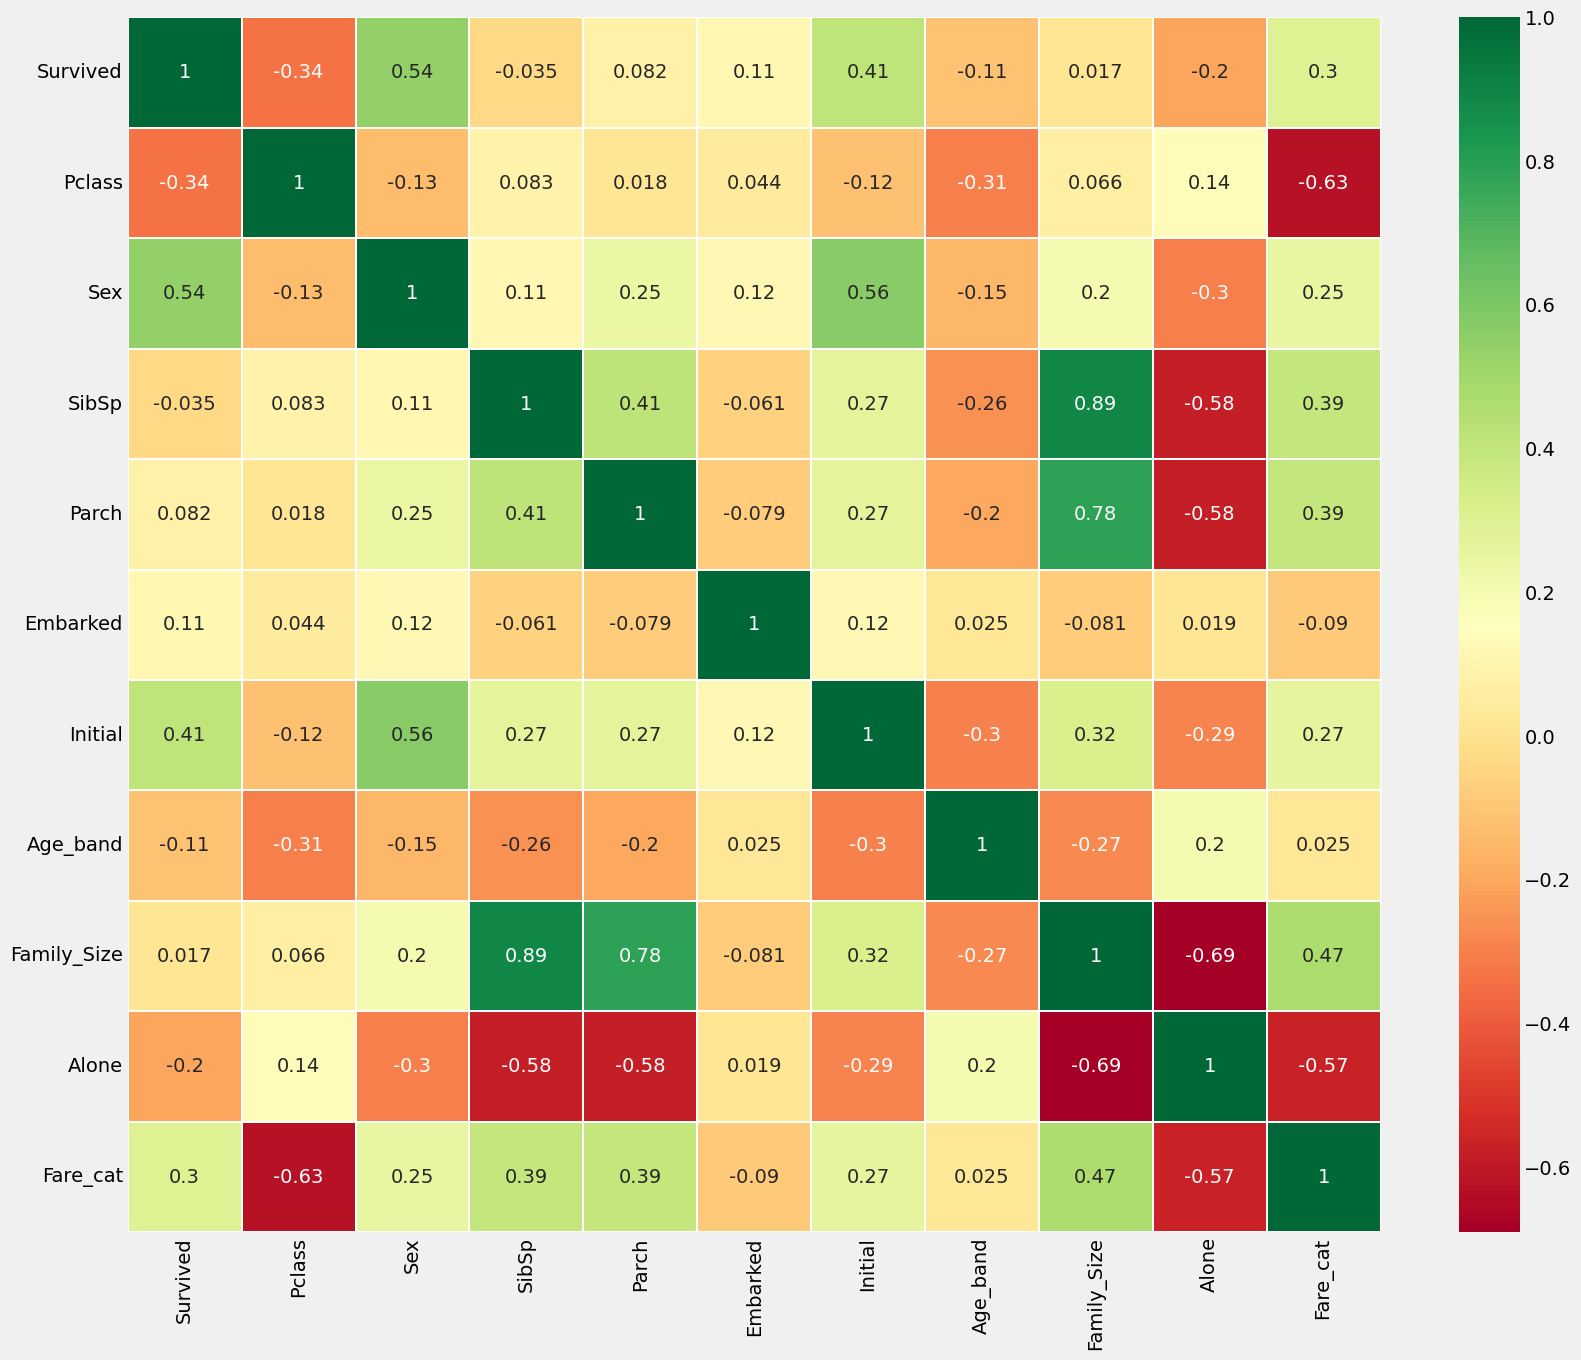

In [24]:
# Correlation heatmap
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.gcf().set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [25]:
# Machine learning models
X = data.drop('Survived', axis=1)
Y = data['Survived']

In [26]:
# Split data
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

In [27]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': svm.SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

In [35]:
# Remove rows with missing values
train_X = train_X.dropna()
train_Y = train_Y[train_X.index]
test_X = test_X.dropna()
test_Y = test_Y[test_X.index]


In [36]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)


In [37]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)


In [39]:
from sklearn.svm import SVC

# Define SVM with probability=True
models['SVM'] = SVC(probability=True)


In [42]:
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

# Define your models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),  # Ensure SVM can output probabilities
    'KNN': KNeighborsClassifier()
}

# Handle missing values
imputer = SimpleImputer(strategy='mean')
train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)

# Dictionary to store metrics
metrics_dict = {}

# Evaluate Logistic Regression
print("Logistic Regression:")
log_reg = models['Logistic Regression']
log_reg.fit(train_X, train_Y)
log_reg_predictions = log_reg.predict(test_X)
log_reg_accuracy = metrics.accuracy_score(test_Y, log_reg_predictions)
log_reg_f1 = metrics.f1_score(test_Y, log_reg_predictions)
log_reg_roc_auc = metrics.roc_auc_score(test_Y, log_reg.predict_proba(test_X)[:, 1])
log_reg_conf_matrix = confusion_matrix(test_Y, log_reg_predictions)
metrics_dict['Logistic Regression'] = [log_reg_accuracy, log_reg_f1, log_reg_roc_auc]

print(f"  Accuracy: {log_reg_accuracy:.4f}")
print(f"  F1 Score: {log_reg_f1:.4f}")
print(f"  ROC AUC: {log_reg_roc_auc:.4f}")
print(f"  Confusion Matrix:\n {log_reg_conf_matrix}\n")

# Evaluate Random Forest
print("Random Forest:")
rf = models['Random Forest']
rf.fit(train_X, train_Y)
rf_predictions = rf.predict(test_X)
rf_accuracy = metrics.accuracy_score(test_Y, rf_predictions)
rf_f1 = metrics.f1_score(test_Y, rf_predictions)
rf_roc_auc = metrics.roc_auc_score(test_Y, rf.predict_proba(test_X)[:, 1])
rf_conf_matrix = confusion_matrix(test_Y, rf_predictions)
metrics_dict['Random Forest'] = [rf_accuracy, rf_f1, rf_roc_auc]

print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  F1 Score: {rf_f1:.4f}")
print(f"  ROC AUC: {rf_roc_auc:.4f}")
print(f"  Confusion Matrix:\n {rf_conf_matrix}\n")

# Evaluate SVM
print("SVM:")
svm = models['SVM']
svm.fit(train_X, train_Y)
svm_predictions = svm.predict(test_X)
svm_accuracy = metrics.accuracy_score(test_Y, svm_predictions)
svm_f1 = metrics.f1_score(test_Y, svm_predictions)
svm_roc_auc = metrics.roc_auc_score(test_Y, svm.predict_proba(test_X)[:, 1])
svm_conf_matrix = confusion_matrix(test_Y, svm_predictions)
metrics_dict['SVM'] = [svm_accuracy, svm_f1, svm_roc_auc]

print(f"  Accuracy: {svm_accuracy:.4f}")
print(f"  F1 Score: {svm_f1:.4f}")
print(f"  ROC AUC: {svm_roc_auc:.4f}")
print(f"  Confusion Matrix:\n {svm_conf_matrix}\n")

# Evaluate KNN
print("KNN:")
knn = models['KNN']
knn.fit(train_X, train_Y)
knn_predictions = knn.predict(test_X)
knn_accuracy = metrics.accuracy_score(test_Y, knn_predictions)
knn_f1 = metrics.f1_score(test_Y, knn_predictions)
knn_roc_auc = metrics.roc_auc_score(test_Y, knn.predict_proba(test_X)[:, 1])
knn_conf_matrix = confusion_matrix(test_Y, knn_predictions)
metrics_dict['KNN'] = [knn_accuracy, knn_f1, knn_roc_auc]

print(f"  Accuracy: {knn_accuracy:.4f}")
print(f"  F1 Score: {knn_f1:.4f}")
print(f"  ROC AUC: {knn_roc_auc:.4f}")
print(f"  Confusion Matrix:\n {knn_conf_matrix}\n")


Logistic Regression:
  Accuracy: 0.8209
  F1 Score: 0.7600
  ROC AUC: 0.8683
  Confusion Matrix:
 [[144  21]
 [ 27  76]]

Random Forest:
  Accuracy: 0.8246
  F1 Score: 0.7487
  ROC AUC: 0.8458
  Confusion Matrix:
 [[151  14]
 [ 33  70]]

SVM:
  Accuracy: 0.8358
  F1 Score: 0.7684
  ROC AUC: 0.8435
  Confusion Matrix:
 [[151  14]
 [ 30  73]]

KNN:
  Accuracy: 0.8060
  F1 Score: 0.7292
  ROC AUC: 0.8454
  Confusion Matrix:
 [[146  19]
 [ 33  70]]



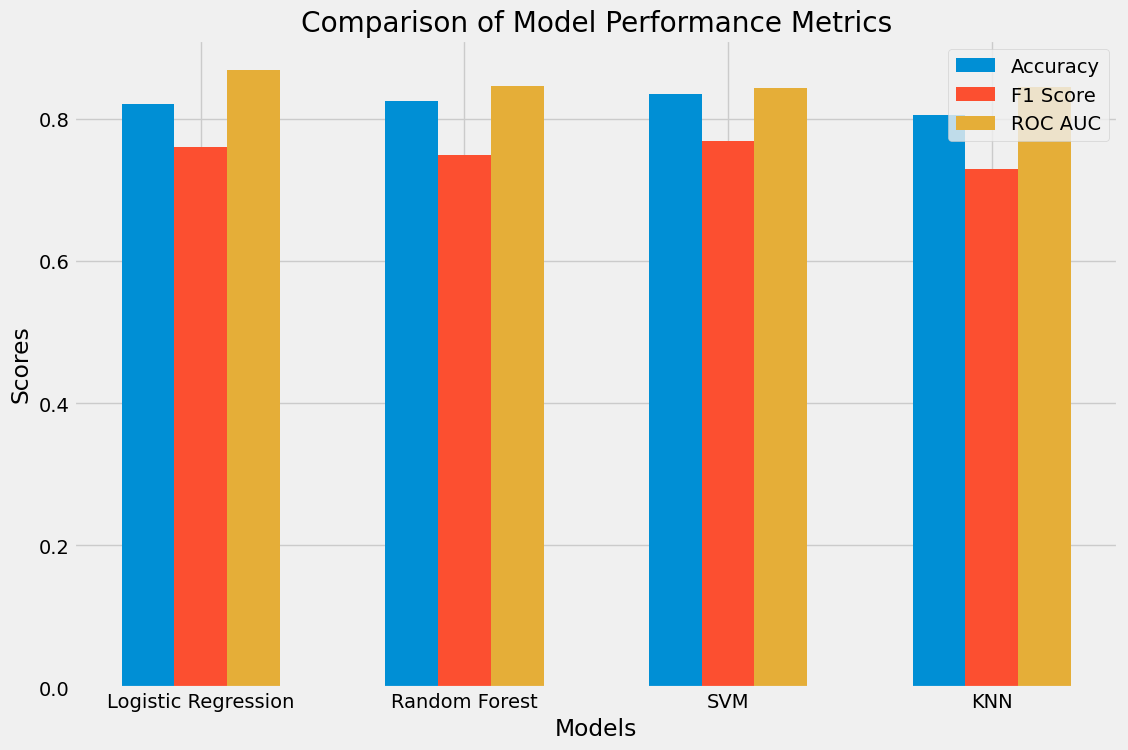

In [43]:
# Define metric names and models
metrics_names = ['Accuracy', 'F1 Score', 'ROC AUC']
num_metrics = len(metrics_names)
models_names = list(metrics_dict.keys())

# Prepare data for plotting
metric_values = np.array(list(metrics_dict.values()))
x = np.arange(len(models_names))

# Plot each metric
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.2  # Width of bars

for i in range(num_metrics):
    ax.bar(x + i * width, metric_values[:, i], width, label=metrics_names[i])

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(models_names)
ax.legend()

plt.show()
